In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

In [2]:
path_to_forcing = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cmems.zarr"
path_to_cafe = "../../../../../1_data_processing/1_1_Forcing/products/Hot_cafe.zarr"
path_to_obs = "../../../../../1_data_processing/1_1_Forcing/products/Hot_obs_filtered.zarr"
export_file_name = "SeapoPym_HOT_CAFE_opti_day_E_coeff"

In [3]:
LATITUDE = 22.75
LONGITUDE = -158
TIME_START = "2005-01-01"
TIME_END = "2010-01-01"

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 322kB
Dimensions:              (latitude: 1, longitude: 1, time: 1827, depth: 3)
Coordinates:
  * depth                (depth) int64 24B 0 1 2
  * latitude             (latitude) float64 8B 22.75
  * longitude            (longitude) int64 8B -158
  * time                 (time) datetime64[ns] 15kB 2005-01-01 ... 2010-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 44kB 24.7...
    U                    (latitude, longitude, time, depth) float64 44kB -0.0...
    V                    (latitude, longitude, time, depth) float64 44kB 0.15...
    mnkc_epi             (latitude, longitude, time) float64 15kB 0.2904 ... ...
    mnkc_hmlmeso         (latitude, longitude, time) float64 15kB 0.8233 ... ...
    mnkc_lmeso           (latitude, longitude, time) float64 15kB 2.403 ... 1...
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 15kB 0.5779 ... ...
    mnkc_umeso           (latitude, longitude, time) float64 15kB 0.79 ... 0....
    npp                  (latitude, longitude, time) float64 15kB 221.1 ... 3...
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 44kB 107....
    zeu                  (latitude, longitude, time) float64 15kB 71.63 ... 7...
    zooc                 (latitude, longitude, time) float64 15kB 0.2527 ... ...
Attributes:
    Conventions:  CF-1.7
    history:      Created on 2024-10-17
    institution:  CLS
    references:   http://www.cls.fr; http://www.seapodym.eu
    source:       SEAPODYM-LMTL 3.0.0
    title:        Global ocean low and mid trophic levels biomass content hin...

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].sel(depth=0).load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth


Magnitude,[[[107.43817318960242 107.62027138586784 111.3608022247511 ... 122.58406536705469 117.0609769555549 112.42833201753643]]]
Units,meter


## CAFE npp


In [6]:
cafe_npp = xr.open_dataset(path_to_cafe, engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(TIME_START, TIME_END))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
cafe_npp.load()

<xarray.Dataset> Size: 29kB
Dimensions:    (time: 1827, latitude: 1, longitude: 1)
Coordinates:
  * latitude   (latitude) float64 8B 22.75
  * longitude  (longitude) int64 8B -158
  * time       (time) datetime64[ns] 15kB 2005-01-01 2005-01-02 ... 2010-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 15kB 349.7 353.3 ... 310.1
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

### Observations


In [7]:
observations = xr.open_zarr(path_to_obs).load()
observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
observations = observations.resample(time="1D").mean().dropna("time")
observations = observations.pint.quantify().pint.to("mg/m^3")
observations = observations * epi_layer_depth
observations = observations.drop_vars("depth")
observations

Magnitude,[[[[129.6241254518878]]] [[[241.93912957042275]]] [[[226.49606461724028]]] [[[297.7116912786574]]] [[[338.10901943263667]]] [[[348.62482773763463]]] [[[414.2199967520759]]] [[[380.37086633863925]]] [[[310.58447115849805]]] [[[299.6403565698716]]] [[[286.7338167009678]]] [[[203.04283404086257]]] [[[182.27868432749716]]] [[[213.14200856879958]]] [[[158.16330671375027]]] [[[213.21478647165335]]] [[[192.88052379372309]]] [[[178.96047463029464]]] [[[192.29199558308798]]] [[[279.3417600824082]]] [[[245.83409341816906]]] [[[251.6896388460537]]] [[[321.7758900737953]]] [[[240.68806733748397]]] [[[285.6867904967255]]] [[[135.38561733182783]]] [[[184.07910842756385]]] [[[113.49811752766878]]] [[[114.75328020306664]]] [[[291.8373150586662]]] [[[208.07113611154097]]] [[[265.3864805985914]]] [[[300.52656827637287]]] [[[405.7243428475462]]] [[[317.43793038041196]]] [[[289.488862617321]]] [[[369.70092582568174]]] [[[402.38246906464065]]] [[[187.91756194824]]] [[[276.50283391179846]]] [[[168.86156744783952]]] [[[165.310175828319]]] [[[209.0217472434997]]] [[[153.79359135232633]]] [[[105.69203672669539]]] [[[121.46032471801634]]] [[[136.65611305691513]]] [[[277.11358627957645]]] [[[401.3576646611965]]] [[[290.014536521321]]] [[[295.556652170673]]] [[[250.23021884103585]]] [[[157.9912873050357]]] [[[222.38519479834522]]] [[[49.59509397421906]]] [[[179.40468654130052]]] [[[203.9030493018046]]] [[[146.13778456973913]]] [[[416.76577798207774]]] [[[145.61375062461659]]] [[[148.20915222988242]]] [[[377.87205331539525]]] [[[188.7746322496145]]] [[[115.03212441610059]]] [[[207.35448677619334]]]]
Units,milligram/meter2
Magnitude,[[[[311.2660665468461]]] [[[411.04654946953013]]] [[[434.4442853402015]]] [[[410.12685963930767]]] [[[425.9698605032181]]] [[[450.29322697950903]]] [[[549.8204501288825]]] [[[601.5568977313856]]] [[[320.1690029650057]]] [[[442.99388134444786]]] [[[355.67831022742035]]] [[[300.9947612036864]]] [[[283.66585739301]]] [[[276.6976430774046]]] [[[298.1719638965375]]] [[[402.4179423232029]]] [[[319.81105274836926]]] [[[456.9291939233906]]] [[[346.7687289469165]]] [[[437.89634413936665]]] [[[418.59746747308213]]] [[[295.20449865110794]]] [[[388.1953942339221]]] [[[303.2075888481008]]] [[[435.41244496878386]]] [[[362.61171823731013]]] [[[325.9052064916851]]] [[[237.661578428888]]] [[[197.9773531469736]]] [[[410.85341661483824]]] [[[497.50541412129627]]] [[[341.6489013266257]]] [[[547.9308393854859]]] [[[524.742692424872]]] [[[504.8848192812326]]] [[[495.06076671485187]]] [[[573.5467022569293]]] [[[684.5289102704819]]] [[[441.3022237706481]]] [[[389.5605894361301]]] [[[295.2949937401673]]] [[[298.6134937077826]]] [[[250.8035280886973]]] [[[192.58467512551408]]] [[[236.8405622245085]]] [[[230.718829341949]]] [[[296.78592909233066]]] [[[409.622869796669]]] [[[494.6507966129079]]] [[[410.0118725290155]]] [[[324.20490677308646]]] [[[331.816723195203]]] [[[479.1847643283798]]] [[[470.81495398792043]]] [[[147.90582627756717]]] [[[222.6260094903661]]] [[[253.23644332570444]]] [[[265.4001656739965]]] [[[591.1972238728096]]] [[[294.8439913315892]]] [[[541.8992237354149]]] [[[443.78218169671544]]] [[[269.09539710001894]]] [[[293.6753429149077]]] [[[306.4898301315927]]]]
Units,milligram/meter2


Create structure for SeapoPym simulation.


In [8]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2025-01-15 13:39:48,253 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [9]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.001, 0.3),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=0.15,
        inv_lambda_max=150,
    )
]
# [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [10]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations.drop_vars("night"))],
)

Set the genetic algorithm meta parameters.


In [11]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=1,
    INDPB=1,
    ETA=5,
    # CXPB=0.8,
    CXPB=0,
    NGEN=5,
    POP_SIZE=100,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [12]:
# constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
#     parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
#     min_energy_coef_value=0,
#     max_energy_coef_value=1,
# )

Finaly, create the Genetic Algorithm.


In [13]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    # constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [14]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52909,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:52923,Total threads: 2
Dashboard: http://127.0.0.1:52925/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52912,


## Run the optimization


In [15]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,0.028344,0.023837,0.006333,0.099047,100,0.0
1,0.020932,0.018608,0.006331,0.088854,100,0.0
2,0.018457,0.016618,0.006350,0.078178,100,0.0
3,0.016186,0.013227,0.006330,0.062513,100,0.0
4,0.017642,0.017255,0.006331,0.089588,100,0.0


Generations: 100%|██████████| 5/5 [00:33<00:00,  6.61s/it]


## Plot the results


In [16]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,0.028344,0.023837,0.006333,0.099047,100,0.0
1,0.020932,0.018608,0.006331,0.088854,100,0.0
2,0.018457,0.016618,0.006350,0.078178,100,0.0
3,0.016186,0.013227,0.006330,0.062513,100,0.0
4,0.017642,0.017255,0.006331,0.089588,100,0.0


In [17]:
viewer.hall_of_fame

D1N1_energy_coefficient   fitness
generation individual                                   
3          7                          0.130174  0.006330
4          27                         0.129961  0.006331
1          91                         0.129873  0.006331
3          36                         0.130595  0.006331
1          54                         0.130691  0.006331
...                                        ...       ...
           69                         0.285705  0.088854
0          35                         0.286298  0.089484
4          36                         0.286395  0.089588
0          13                         0.288071  0.091383
           80                         0.295032  0.099047

[500 rows x 2 columns]

In [18]:
viewer.fitness_evolution()

In [19]:
viewer.box_plot(1, nbest=1000)

# Generate plots at each station


In [20]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")

Best individual: [0.0, 0.0, 0.13017392639417028, 10.38, -0.11, 150.0, 0.15]


## Run simulation


In [21]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["D1N1"]),
)

model_print.run()

## Plot


### Taylor Diagram


Convert to pandas series.


In [22]:
biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .reset_index()
    .set_index("time")["biomass"]
)
observations_day_pandas = (
    observations.pint.dequantify().day.dropna("time").to_dataframe().reset_index().set_index("time")["day"]
)
observations_night_pandas = (
    observations.pint.dequantify().night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]


Then resample to month.


In [23]:
monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred = biomass_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred.index = monthly_pred.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [28]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + E coeff. optimization",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


fig.add_trace(
    go.Scatter(
        x=monthly_obs_day.index,
        y=monthly_obs_day,
        fill=None,
        mode="lines",
        line={"color": "red", "width": 1},
        name="Observations (day)",
    )
)

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        fill="tonexty",
        mode="lines",
        line={"color": "rgba(180, 180, 180, 0.2)", "width": 1},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred.index,
        y=monthly_pred,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions",
    )
)
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [29]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.5099298854265525, 0.45078763840407193]
norm STD [0.3905087279973812, 0.30937591765393757]
bias [-0.009609543278766772, -1.2815961382578605]
NRMSE [0.8684658454945628, 0.9037631215244366]
name ['HOT Day', 'HOT Night']


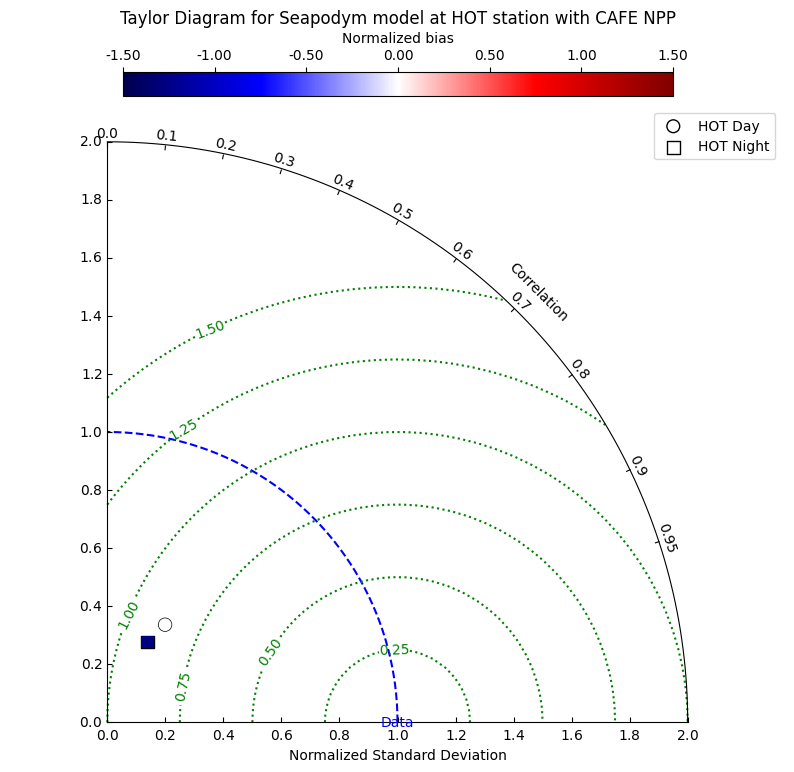

In [30]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred]
all_obs = [monthly_obs_day]

all_names = ["HOT Day"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title("Taylor Diagram for Seapodym model during day (CAFE npp) : HOT station + E coeff. optimization")

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [32]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,HOT Day,0.509930,0.390509,-0.009610,0.868466
1,HOT Night,0.450788,0.309376,-1.281596,0.903763
